# UNET Multiclass Semantic segmentation with autoencoders weights

## Model with autoenconder

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
pip install -U segmentation-models

     |████████████████████████████████| 50 kB 4.1 MB/s 


Importar bibliotecas

In [1]:
import numpy as np
import cv2
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Input, Conv2DTranspose
from tensorflow.keras.models import Sequential
import os
import tensorflow
import keras
from keras.models import Model
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
SIZE=256

In [3]:
img_data=[]
path1 = '/content/drive/MyDrive/DB_tuta_final/train/train_images_patches_filtrado/'
files=os.listdir(path1)
for i in tqdm(files):
    img=cv2.imread(path1+'/'+i,1)   #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    img_data.append(img_to_array(img))
    

100%|██████████| 1628/1628 [00:08<00:00, 189.22it/s]


In [4]:
img_array = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
img_array = img_array.astype('float32') / 255.

In [5]:
#In the interest of time let us train on 500 images
img_array2 = img_array[200:700]

## Model

In [47]:
"""
@author: Sreenivas Bhattiprolu
convolutional, encoder, decoder blocks to build autoencoder and unet models
- Encoder would be the same for both autoencoder and Unet.
- Decoder path would be different for U-Net as we need to add concatenation. 
"""

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

#Convolutional block to be used in autoencoder and U-Net
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block for autoencoder (no skip connections)
def decoder_block(input, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = conv_block(x, num_filters)
    return x

#Encoder will be the same for Autoencoder and U-net
#We are getting both conv output and maxpool output for convenience.
#we will ignore conv output for Autoencoder. It acts as skip connections for U-Net
def build_encoder(input_image):
    #inputs = Input(input_shape)

    s1, p1 = encoder_block(input_image, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    encoded = conv_block(p4, 1024) #Bridge
    
    return encoded

#Decoder for Autoencoder ONLY. 
def build_decoder(encoded):
    d1 = decoder_block(encoded, 512)
    d2 = decoder_block(d1, 256)
    d3 = decoder_block(d2, 128)
    d4 = decoder_block(d3, 64)
    
    decoded = Conv2D(3, 3, padding="same", activation="sigmoid")(d4) #softmax
    return decoded

#Use encoder and decoder blocks to build the autoencoder. 
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    autoencoder = Model(input_img, build_decoder(build_encoder(input_img)))
    return(autoencoder)

# model=build_autoencoder((256, 256, 3))
# print(model.summary())

#Decoder block for unet
#skip features gets input from encoder for concatenation
def decoder_block_for_unet(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
#def build_unet(input_shape):
def build_unet(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block_for_unet(b1, s4, 512)
    d2 = decoder_block_for_unet(d1, s3, 256)
    d3 = decoder_block_for_unet(d2, s2, 128)
    d4 = decoder_block_for_unet(d3, s1, 64)

 #   outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(d4)

    model = Model(inputs, outputs, name="U-Net")
    print(model.summary())
    return model


#Define the autoencoder model. 

In [7]:

#Experiment with various optimizers and loss functions
#from models import build_autoencoder, build_encoder, build_unet

autoencoder_model=build_autoencoder(img.shape)
autoencoder_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
print(autoencoder_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0     

In [8]:
#Train the autoencoder

history = autoencoder_model.fit(img_array2, img_array2,
        epochs=100, verbose=1)

Epoch 1/100
16/16 [==============================] - 20s 804ms/step - loss: 0.0334 - accuracy: 0.9013
Epoch 2/100
16/16 [==============================] - 11s 670ms/step - loss: 0.0276 - accuracy: 0.9396
Epoch 3/100
16/16 [==============================] - 11s 670ms/step - loss: 0.0219 - accuracy: 0.9451
Epoch 4/100
16/16 [==============================] - 11s 670ms/step - loss: 0.0141 - accuracy: 0.9468
Epoch 5/100
16/16 [==============================] - 11s 670ms/step - loss: 0.0113 - accuracy: 0.9448
Epoch 6/100
16/16 [==============================] - 11s 671ms/step - loss: 0.0103 - accuracy: 0.9463
Epoch 7/100
16/16 [==============================] - 11s 671ms/step - loss: 0.0099 - accuracy: 0.9443
Epoch 8/100
16/16 [==============================] - 11s 670ms/step - loss: 0.0094 - accuracy: 0.9467
Epoch 9/100
16/16 [==============================] - 11s 670ms/step - loss: 0.0104 - accuracy: 0.9438
Epoch 10/100
16/16 [==============================] - 11s 670ms/step - loss: 0.009

# Save Model

In [9]:
autoencoder_model.save('/content/drive/MyDrive/DB_tuta_final/autoencoder_500imgs_100epochs.h5')

#Load the model 

In [ ]:

from keras.models import load_model
autoencoder_model = load_model('/content/drive/MyDrive/DB_tuta_final/autoencoder_500imgs_100epochs.h5', compile=False)

# Test on a few images

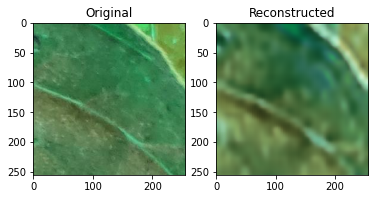

In [11]:
import random
num=random.randint(0, len(img_array2)-1)
test_img = np.expand_dims(img_array[num], axis=0)
pred = autoencoder_model.predict(test_img)

plt.subplot(1,2,1)
plt.imshow(test_img[0])
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(pred[0].reshape(SIZE,SIZE,3))
plt.title('Reconstructed')
plt.show()

#Extract weights only for the encoder part of the Autoencoder. 

In [ ]:
#from models import build_autoencoder
#from keras.models import load_model
autoencoder_model = load_model('/content/drive/MyDrive/DB_tuta_final/autoencoder_500imgs_100epochs.h5', compile=False)

In [12]:
#Now define encoder model only, without the decoder part. 
input_shape = (256, 256, 3)
input_img = Input(shape=input_shape)

encoder = build_encoder(input_img)
encoder_model = Model(input_img, encoder)
print(encoder_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_18 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_18 (Activation)   (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_19 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
activation_19 (Activation)   (None, 256, 256, 64)      0   

In [14]:
num_encoder_layers = len(encoder_model.layers) #35 layers in our encoder. 
print(num_encoder_layers)

35


In [15]:
#Get weights for the 35 layers from trained autoencoder model and assign to our new encoder model 
for l1, l2 in zip(encoder_model.layers[:35], autoencoder_model.layers[0:35]):
    l1.set_weights(l2.get_weights())


In [16]:
#Verify if the weights are the same between autoencoder and encoder only models. 
autoencoder_weights = autoencoder_model.get_weights()[0][1]
encoder_weights = encoder_model.get_weights()[0][1]

In [17]:
#Save encoder weights for future comparison
np.save('/content/drive/MyDrive/DB_tuta_final/pretrained_encoder-weights.npy', encoder_weights )

In [18]:
#Check the output of encoder_model on a test image
#Should be of size 16x16x1024 for our model
temp_img = cv2.imread('/content/drive/MyDrive/DB_tuta_final/train/train_images_patches_filtrado/20210331_082923_059.png',1)
temp_img = temp_img.astype('float32') / 255.
temp_img = np.expand_dims(temp_img, axis=0)
temp_img_encoded=encoder_model.predict(temp_img)

In [21]:
n_classes = 3

In [48]:
################################################
#Now let us define a Unet with same encoder part as out autoencoder. 
#Then load weights from the original autoencoder for the first 35 layers (encoder)
input_shape = (256, 256, 3)

unet_model = build_unet(input_shape)

TypeError: ignored

In [50]:


def get_model():#Modelo
    return build_unet(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model() #obter modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compilar com categorical crossentropy-semantic segmetnation
model.summary() #printar sumário

NameError: ignored

In [28]:
#Print layer names for each model to verify the layers....
#First 35 layers should be the same in both models. 
unet_layer_names=[]
for layer in unet_model.layers:
    unet_layer_names.append(layer.name)

In [29]:
autoencoder_layer_names = []
for layer in autoencoder_model.layers:
    autoencoder_layer_names.append(layer.name)

In [30]:
#Make sure the first 35 layers are the same. Remember that the exct names of the layers will be different.
###########

#Set weights to encoder part of the U-net (first 35 layers)
for l1, l2 in zip(unet_model.layers[:35], autoencoder_model.layers[0:35]):
    l1.set_weights(l2.get_weights())

In [35]:
#from keras.optimizers import Adam
import segmentation_models as sm
unet_model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])
#unet_model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()
print(unet_model.output_shape)



Segmentation Models: using `keras` framework.
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 256, 256, 64) 256         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 256, 256, 64) 0           batch_normalization_46[0][0]     
________________________________________________

In [36]:
unet_model.save('unet_model_weights.h5')

Unet_model

In [37]:
train_image_directory = '/content/drive/MyDrive/DB_tuta_final/train/train_images_patches_filtrado' 
train_mask_directory = '/content/drive/MyDrive/DB_tuta_final/train/train_masks_patches_filtrado/'
test_image_directory = '/content/drive/MyDrive/DB_test_tuta_separated_PS_filtrado/test_2/256_images/'
test_mask_directory = '/content/drive/MyDrive/DB_test_tuta_separated_PS_filtrado/test_2/256_masks/'

In [38]:
SIZE = 256
train_image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
train_mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.
test_image_dataset = []
test_mask_dataset = []

In [40]:
train_images = os.listdir(train_image_directory)
for i, image_name in enumerate(train_images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'png'):
        #print(image_directory+image_name)
        train_images = cv2.imread(train_image_directory+image_name, 1)
        #image = Image.fromarray(image)
        #image = image.resize((SIZE, SIZE))
        train_image_dataset.append(train_images)

In [41]:
test_images = os.listdir(test_image_directory)
for i, image_name in enumerate(test_images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'png'):
        #print(image_directory+image_name)
        test_images = cv2.imread(test_image_directory+image_name, 1)
        #image = Image.fromarray(image)
        #image = image.resize((SIZE, SIZE))
        test_image_dataset.append(test_images)

In [43]:
train_masks = os.listdir(train_mask_directory)
for i, mask_name in enumerate(train_masks):
    if (mask_name.split('.')[1] == 'png'):
        mask = cv2.imread(train_mask_directory+mask_name, 0)
        #mask = Image.fromarray(image)
        #mask = image.resize((SIZE, SIZE))
        train_mask_dataset.append(train_masks)

In [42]:
test_masks = os.listdir(test_mask_directory)
for i, mask_name in enumerate(test_masks):
    if (mask_name.split('.')[1] == 'png'):
        mask = cv2.imread(test_mask_directory+mask_name, 0)
        #mask = Image.fromarray(image)
        #mask = image.resize((SIZE, SIZE))
        test_mask_dataset.append(test_masks)

In [45]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder() # só funciona em vetor unico e temos 3 dimensoes, com isso faz reshape no vetor
n, h, w = train_mask_dataset.shape # separar dimensões do formato da mascara #numero de bandas, altura e largura
masks_reshaped = train_masks_dataset.reshape(-1,1) # reshape para? (para normalizar)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped) # transformar e adequar, reencoda tudo
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w) # 

np.unique(train_masks_encoded_original_shape) # mostrar legendas das mascaras

AttributeError: ignored

In [ ]:
labelencoder = LabelEncoder() # só funciona em vetor unico e temos 3 dimensoes, com isso faz reshape no vetor
n, h, w = test_masks.shape # separar dimensões do formato da mascara #numero de bandas, altura e largura
test_masks_reshaped = test_masks.reshape(-1,1) # reshape para? (para normalizar)
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped) # transformar e adequar, reencoda tudo
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(n, h, w) # 

np.unique(test_masks_encoded_original_shape) # mostrar legendas das mascaras

In [46]:
from tensorflow.keras.utils import normalize

#train_images = np.expand_dims(train_images, axis=3) # expandir dimensão de uma banda no fim # pulei esta, pois estava perdendo info das bandas
train_images = normalize(train_images, axis=1) # normalizar para que o valor maximo de pixels seja 255

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3) # expandir dimensão das mascaras..
# (256,256) -> (256,256,1) - np.expand_dims(x, axis = -1)

TypeError: ignored

In [ ]:
#train_images = np.expand_dims(train_images, axis=3) # expandir dimensão de uma banda no fim # pulei esta, pois estava perdendo info das bandas
test_images = normalize(test_images, axis=1) # normalizar para que o valor maximo de pixels seja 255

test_masks_input = np.expand_dims(test_masks_encoded_original_shape, axis=3) # expandir dimensão das mascaras..
# (256,256) -> (256,256,1) - np.expand_dims(x, axis = -1)

In [ ]:
#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)), 3) /255.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 0)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.20, random_state = 0)

In [ ]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes)) # rodar também sem esta linha


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


Sanity check

In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [ ]:
#Load unet model and load pretrained weights
from models import build_autoencoder, build_encoder, build_unet
from keras.optimizers import Adam
import segmentation_models as sm

input_shape = (256, 256, 3)

pre_trained_unet_model = build_unet(input_shape)
pre_trained_unet_model.load_weights('unet_model_weights.h5')
pre_trained_unet_model_weights = pre_trained_unet_model.get_weights()[0][1]

In [ ]:
#Load previously saved pretrained encoder weights just for comparison with the unet weights (Sanity check)
pretrained_encoder_wts = np.load('pretrained_encoder-weights.npy')

if pre_trained_unet_model_weights.all() == pretrained_encoder_wts.all():
    print("Both weights are identical")
else: 
    print("Something wrong, weghts are different")

In [ ]:
#Compile both models, one with random weights and the other with pretrained
pre_trained_unet_model.compile('Adam', loss=sm.losses.binary_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

In [ ]:
pre_trained_unet_model_history = pre_trained_unet_model.fit(X_train, y_train_cat, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False,
                    epochs=25)


In [ ]:

pre_trained_unet_model.save('pre_trained_unet_model_25epochs.h5')

In [ ]:
#Save history for future visualization and plotting
# convert the history.history dict to a pandas DataFrame: 
    #and save as csv
import pandas as pd    
hist_df = pd.DataFrame(pre_trained_unet_model_history.history) 
hist_csv_file = 'pre_trained_unet_model_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# OR save as numpy
#Save history if you want to plot loss and IoU later
np.save('pre_trained_unet_model_history.npy', pre_trained_unet_model_history.history)


In [ ]:

#Load saved history
pre_trained_unet_model_history = np.load('pre_trained_unet_model_history.npy', allow_pickle='TRUE').item()

In [ ]:
#PLot history to see which one converged fast
history = random_wt_unet_model_history

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
#For each model check the IoU and verify few random images
from keras.models import load_model

pre_trained_unet_model = load_model('pre_trained_unet_model_25epochs.h5', compile=False)

my_model = pre_trained_unet_model

In [ ]:
import random
test_img_number = random.randint(0, X_test.shape[0]-1)
#test_img_number = 119
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (my_model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


In [ ]:
y_pred=model.predict(X_val)
y_pred_argmax=np.argmax(y_pred, axis=3) #-1

In [ ]:
from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_val[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
print("IoU for class1 is: ", class1_IoU)
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
print("IoU for class2 is: ", class2_IoU)
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])
print("IoU for class3 is: ", class3_IoU)

In [ ]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
#Calculate IoU for all test images and average
 
import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (my_model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)    